<a href="https://colab.research.google.com/github/hnidey13/tesis_SVD_t-SVDM/blob/main/Clasificaci%C3%B3n_Iris_t_SVDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Permitimos acceso a los datos

In [32]:
# https://medium.com/@ashwindesilva/how-to-use-google-colaboratory-to-clone-a-github-repository-e07cf8d3d22b
# https://stackoverflow.com/questions/48350226/methods-for-using-git-with-google-colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import os
#os.chdir('/content/gdrive/MyDrive/')
# !git clone https://github.com/hnidey13/tensor-fmri.git

os.chdir('/content/gdrive/MyDrive/tensor-fmri')
#!git pull


Mounted at /content/gdrive


Importamos paquetes y módulos


In [33]:
import numpy as np
from data.synthetic_data import stripes
import tensor.tensor_product_wrapper as tp
from utils.plotting_utils import montage_array, slice_subplots
import matplotlib.pyplot as plt
import similarity_metrics as sm
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Elegimos alguna de 3 opciones para la matriz de transformación.

* 'f' : facewise product (producto en términos de cara)
* 't' : t-product (transformada de Fourier)
* 'c': c-product (transformada discreta del coseno)

In [34]:
prod_type = 't'

La proyección del tensor $\mathcal{A}$ en el espacio generado por los cortes laterales del tensor $\boldsymbol{\mathcal{U}}$ es: $$\boldsymbol{\mathcal{U}} \star_M \boldsymbol{\mathcal{U}}^\top \star_M \boldsymbol{\mathcal{A}}$$

In [35]:
def projection(A, U, prod_type):
    training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type)
    return tp.ten_prod(U, training_coeff, prod_type=prod_type)

Cargamos los datos Iris y visualizamos

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


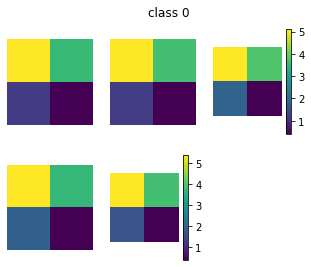

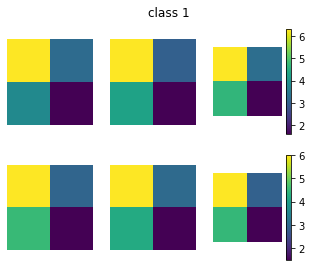

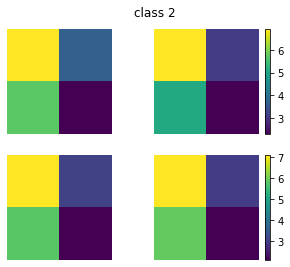

(2, 15, 2)
[0 1 1 0 2 1 2 0 0 2 1 0 2 1 1]


In [36]:
np.random.seed(20)

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X, y = iris.data, iris.target
X_train,X_test,training_labels,test_labels=train_test_split(X,y,test_size=0.1,random_state=1)

print(iris.feature_names)
print(iris.target_names)

training_data = np.transpose(X_train.reshape(-1,2,2),(1,0,2))
test_data = np.transpose(X_test.reshape(-1,2,2),(1,0,2))

# visualize data
num_classes = 3
for i in range(num_classes):
    slice_subplots(test_data[:, test_labels == i, :], axis=1, title='class ' + str(i))
    plt.show()

print(test_data.shape)
print(test_labels)

Calculamos $\boldsymbol{\mathcal{U}}_i$

In [37]:
num_classes = len(np.unique(training_labels))
k = 1

U = []
for i in range(num_classes):
    u, _, _, _ = tp.ten_svd(training_data[:, training_labels == i, :], k, prod_type=prod_type)
    U.append(u)

Calculamos los resultados para el conjunto de entrenamiento y prueba

train accuracy = 97.04
test accuracy = 100.00


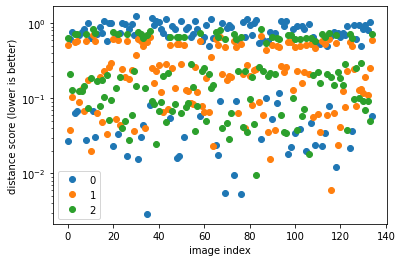

In [38]:
training_error = np.zeros([num_classes, training_data.shape[1]])
test_error = np.zeros([num_classes, test_data.shape[1]])
for i in range(num_classes):
    training_projection = projection(training_data, U[i], prod_type=prod_type)
    training_error[i, :] = sm.frobenius_metric(training_data, training_projection, axis=1)

    test_projection = projection(test_data, U[i], prod_type=prod_type)
    test_error[i, :] = sm.frobenius_metric(test_data, test_projection, axis=1)


# Clasificación
training_predicted_classes = np.argmin(training_error, axis=0).reshape(-1)
test_predicted_classes = np.argmin(test_error, axis=0).reshape(-1)

# Resultados
training_num_correct = np.sum(training_predicted_classes == training_labels)
training_accuracy = training_num_correct / training_data.shape[1]

test_num_correct = np.sum(test_predicted_classes == test_labels)
test_accuracy = test_num_correct / test_data.shape[1]

print('train accuracy = %0.2f' % (100 * training_accuracy))
print('test accuracy = %0.2f' % (100 * test_accuracy))

# Graficamos
plt.figure()
for i in range(num_classes):
    plt.semilogy(training_error[i, :], 'o', label=i)

plt.xlabel('image index')
plt.ylabel('distance score (lower is better)')
plt.legend()
plt.show()

Matriz de confusión

In [39]:
pd.set_option('display.max_colwidth',12)
confusion_matrix_df = pd.DataFrame( confusion_matrix(test_labels,test_predicted_classes) )
confusion_matrix_df = confusion_matrix_df.rename(columns = {0:iris.target_names[0],1:iris.target_names[1],2:iris.target_names[2]},
                                                 index = {0:iris.target_names[0],1:iris.target_names[1],2:iris.target_names[2]})
confusion_matrix_df

,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,6,0
virginica,0,0,4


Visualizamos los tensores proyectados

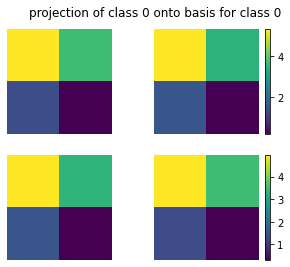

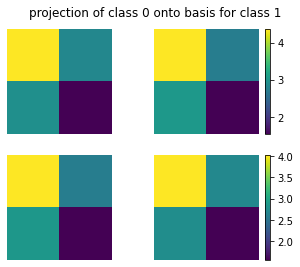

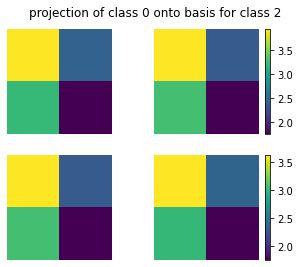

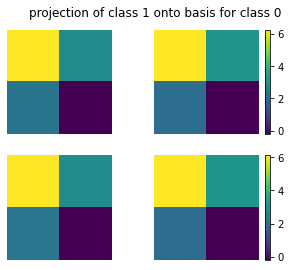

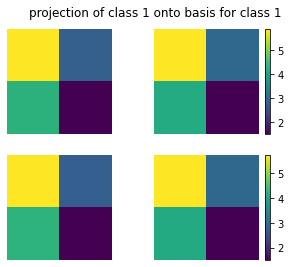

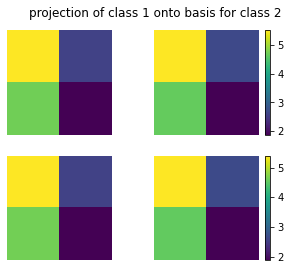

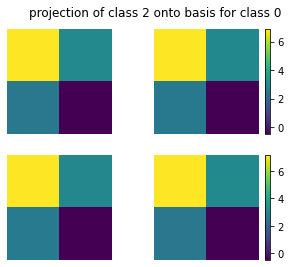

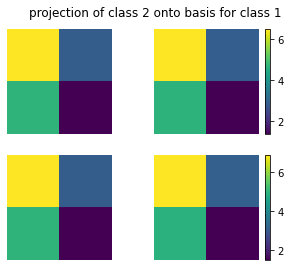

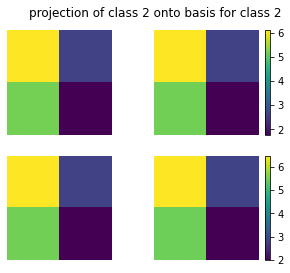

In [40]:
for j in range(num_classes):
    for i in range(num_classes):
        A = projection(training_data[:, training_labels == j, :], U[i], prod_type=prod_type)
        slice_subplots(A[:, :4, :], axis=1, title='projection of class ' + str(j) + ' onto basis for class ' + str(i))
        plt.show()
